### Imported all the necessary data, and loaded in the data set

In [226]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import *
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
import scipy.stats as stats

import warnings
warnings.filterwarnings("ignore")

path = '../../../data/kc_housing_data.csv'
all_data = pd.read_csv('https://raw.githubusercontent.com/learn-co-students/bsc-phase-two-project/main/data/kc_house_data.csv')

In [122]:
all_data

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,5/21/2014,360000.0,3,2.50,1530,1131,3.0,0.0,0.0,...,8,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509
21593,6600060120,2/23/2015,400000.0,4,2.50,2310,5813,2.0,0.0,0.0,...,8,2310,0.0,2014,0.0,98146,47.5107,-122.362,1830,7200
21594,1523300141,6/23/2014,402101.0,2,0.75,1020,1350,2.0,0.0,0.0,...,7,1020,0.0,2009,0.0,98144,47.5944,-122.299,1020,2007
21595,291310100,1/16/2015,400000.0,3,2.50,1600,2388,2.0,NaN,0.0,...,8,1600,0.0,2004,0.0,98027,47.5345,-122.069,1410,1287


In [123]:
all_data.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

### Dropping Irrelevant Columns

In [180]:
df = all_data.drop(['view', 'zipcode', 'lat', 'long', 'sqft_above', 'sqft_living15', 'sqft_lot15'], axis=1)

### Creating new variables

In [181]:
yrs = [int(x[-4:]) for x in df['date']]
df['date'] = yrs

In [182]:
for x in range(len(df)):
    if df['yr_renovated'][x] == True:
        if df['yr_renovated'][x] > 0:
            df['yr_built'][x] = df['yr_renovated'][x]

In [183]:
df['renovated'] = [int(x) for x in (df['yr_renovated'] > 0)]

In [184]:
df['yr_renovated/built'] = df['yr_built']

In [185]:
df['age'] = df['date'] - df['yr_renovated/built']

In [186]:
df.drop(['yr_renovated','yr_built', 'date', 'yr_ren'], axis=1, inplace=True)

In [187]:
df

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_basement,renovated,yr_renovated/built,age
0,7129300520,221900.0,3,1.00,1180,5650,1.0,NaN,3,7,0.0,0,1955,59
1,6414100192,538000.0,3,2.25,2570,7242,2.0,0.0,3,7,400.0,1,1951,63
2,5631500400,180000.0,2,1.00,770,10000,1.0,0.0,3,6,0.0,0,1933,82
3,2487200875,604000.0,4,3.00,1960,5000,1.0,0.0,5,7,910.0,0,1965,49
4,1954400510,510000.0,3,2.00,1680,8080,1.0,0.0,3,8,0.0,0,1987,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,360000.0,3,2.50,1530,1131,3.0,0.0,3,8,0.0,0,2009,5
21593,6600060120,400000.0,4,2.50,2310,5813,2.0,0.0,3,8,0.0,0,2014,1
21594,1523300141,402101.0,2,0.75,1020,1350,2.0,0.0,3,7,0.0,0,2009,5
21595,291310100,400000.0,3,2.50,1600,2388,2.0,NaN,3,8,0.0,0,2004,11


In [211]:
df.corr()['price']

id                   -0.016772
price                 1.000000
bedrooms              0.308787
bathrooms             0.525906
sqft_living           0.701917
sqft_lot              0.089876
floors                0.256804
waterfront            0.276295
condition             0.036056
grade                 0.667951
renovated             0.117543
yr_renovated/built    0.053953
age                  -0.053890
Name: price, dtype: float64

In [244]:
df

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_basement,renovated,yr_renovated/built,age
0,7129300520,221900.0,3,1.00,1180,5650,1.0,NaN,3,7,0.0,0,1955,59
1,6414100192,538000.0,3,2.25,2570,7242,2.0,0.0,3,7,400.0,1,1951,63
2,5631500400,180000.0,2,1.00,770,10000,1.0,0.0,3,6,0.0,0,1933,82
3,2487200875,604000.0,4,3.00,1960,5000,1.0,0.0,5,7,910.0,0,1965,49
4,1954400510,510000.0,3,2.00,1680,8080,1.0,0.0,3,8,0.0,0,1987,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,360000.0,3,2.50,1530,1131,3.0,0.0,3,8,0.0,0,2009,5
21593,6600060120,400000.0,4,2.50,2310,5813,2.0,0.0,3,8,0.0,0,2014,1
21594,1523300141,402101.0,2,0.75,1020,1350,2.0,0.0,3,7,0.0,0,2009,5
21595,291310100,400000.0,3,2.50,1600,2388,2.0,NaN,3,8,0.0,0,2004,11


In [257]:
X = sm.add_constant(df[['sqft_living', 'floors', 'grade', 'age']])
Y = df['price']
model_1 = sm.OLS(Y, X)
results = model_1.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.605
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     8279.
Date:                Mon, 28 Jun 2021   Prob (F-statistic):               0.00
Time:                        15:24:15   Log-Likelihood:            -2.9735e+05
No. Observations:               21597   AIC:                         5.947e+05
Df Residuals:                   21592   BIC:                         5.948e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.119e+06   1.49e+04    -75.078      0.000   -1.15e+06   -1.09e+06
sqft_living   176.9864      2.648     66.828      0.000     171.795     182.177
floors       3.177e+04   3507.883      9.057      0.000    2.49e+04    3.86e+04
grade        1.405e+05   2242.111     62.647      0.000    1.36e+05    1.45e+05
age          3888.8182     64.109     60.659      0.000    3763.160    4014.477
==============================================================================
Omnibus:                    17823.141   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1361634.604
Skew:                           3.489   Prob(JB):                         0.00
Kurtosis:                      41.268   Cond. No.                     2.18e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.18e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [258]:
residuals = results.resid
residuals

0       -111906.399060
1        -89143.184153
2        -30223.438858
3        171032.383765
4         67792.409626
             ...      
21592    -29757.616230
21593    -80481.339576
21594    274838.207040
21595      6290.828939
21596    193848.388823
Length: 21597, dtype: float64

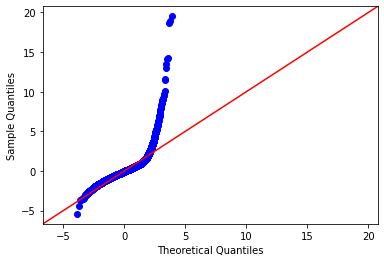

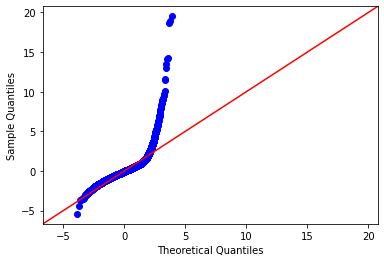

In [259]:
sm.graphics.qqplot(residuals, dist=stats.norm, fit=True, line='45')

In [254]:
preds = results.predict()

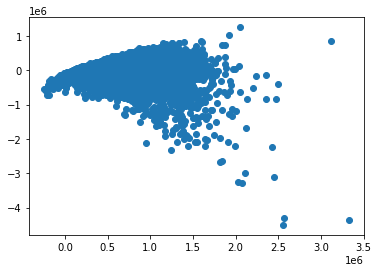

In [261]:
resids = preds - Y
plt.scatter(preds, resids)